In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import pickle
from tqdm import tqdm
import copy

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [4]:
from utils.model import BayesianCNNSingleFC

In [5]:
from bitflip import bitflip_float32

In [6]:
def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    torch.manual_seed(42)
    
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [7]:
train_loader, test_loader = load_data(batch_size=54)

In [8]:
device = torch.device("cuda")

In [9]:
num_classes = 10

In [10]:
bayesian_model =BayesianCNNSingleFC(num_classes=num_classes, device=device).to(device)

In [11]:
model_path = 'results_eurosat/bayesian_cnn_model_std10_100_epoch.pth'
guide_path = 'results_eurosat/bayesian_cnn_guide_std10_100_epoch_guide.pth'
pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_100_epoch.pkl'

#guide = AutoDiagonalNormal(bayesian_model).to(device)

#pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

#original_param_store = {}

#for name, value in pyro.get_param_store().items():
#    print(f"{name}: {value.shape}")
#    original_param_store[name] = torch.tensor(value.data, requires_grad=value.requires_grad)

In [ ]:
class Injector:
    def __init__(self, trained_model, device, test_loader, num_samples):
        """
        Initializes SEU injector
        """

        #initialize device
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.trained_model = trained_model.to(self.device)
        self.test_loader = test_loader
        self.trained_model.eval()
        self.num_samples = num_samples
        
        self.guide = AutoDiagonalNormal(self.trained_model).to(self.device)
        pyro.get_param_store().clear()
        pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

        #initial_Accuracy = self.return_accuracy(num_samples)
        initial_labels, initial_predictions, initial_logits, initial_probs = self.predict_data_probs(self.num_samples)
        self.initial_accuracy = self.return_accuracy(initial_labels, initial_predictions)
        
        #print accuracy before SEU
        print(f"Initial accuracy: {self.initial_accuracy}")
        
    def predict_data_probs(self, num_samples=10):
        all_labels = []
        all_predictions = []
        all_logits = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Evaluating"):
                images, labels = images.to(self.device), labels.to(self.device)

                logits_mc = torch.zeros(num_samples, images.size(0), self.trained_model.fc1.out_features).to(device)

                for i in range(num_samples):
                    guide_trace = pyro.poutine.trace(self.guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(self.trained_model, trace=guide_trace)
                    logits = replayed_model(images)
                    logits_mc[i] = logits

                avg_logits = logits_mc.mean(dim=0)
                predictions = torch.argmax(avg_logits, dim=1)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                all_logits.extend(avg_logits.cpu().numpy())
                all_probs.extend(F.softmax(avg_logits, dim=1).cpu().numpy())

        return all_labels, all_predictions, all_logits, all_probs

    def return_accuracy(self, all_labels, all_predictions):
        #all_labels, all_predictions, all_logits, all_probs = self.predict_data_probs(num_samples)
        cm = confusion_matrix(all_labels, all_predictions)
        accuracy = np.trace(cm) / np.sum(cm)

        return accuracy
    
    def run_seu_autodiagonal_normal(self, location_index, bit_i, parameter_name="loc", num_samples=10):
        """
        Run SEU on the AutoDiagonalNormal guide
        """

        assert parameter_name in ["loc", "scale"], "Parameter name must be 'loc' or 'scale'."
        assert bit_i in range(0, 33), "Location index must be between 0 and 9."

        if parameter_name == "loc":
            param_store_name = "AutoDiagonalNormal.loc"
        elif parameter_name == "scale":
            param_store_name = "AutoDiagonalNormal.scale"

        pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

        with torch.no_grad():
            param_dict = {}

            for name, value in pyro.get_param_store().items():
                #print(f"{name}: {value.shape}")
                #print(value)
                param_dict[name] = value.cpu().detach().numpy()

            tensor_cpu = param_dict[param_store_name]

            original_val = tensor_cpu[0]
            seu_val = bitflip_float32(original_val, bit_i)


            print(f"Original value: {original_val}, SEU value: {seu_val}")

            # Get the parameter
            param = pyro.get_param_store().get_param(param_store_name)

            # Modify it safely by creating a new tensor
            new_param = param.clone()
            new_param[location_index] = seu_val  # New Value

            # Update the parameter store
            if parameter_name == "loc":
                pyro.get_param_store().__setitem__(param_store_name, new_param) # 74%
                #param_store[param_store_name].data.copy_(change_item(param_store_name, location_index, seu_val)) #25%
                #pyro.get_param_store()[param_store_name].data[location_index] = seu_val # 25%
            elif parameter_name == "scale":
                pyro.get_param_store().__setitem__(param_store_name, new_param) #10%
                #pyro.get_param_store()[param_store_name].data[location_index] = seu_val

        #print accuracy after SEU
        self.guide = AutoDiagonalNormal(bayesian_model).to(device)
    

        try:
            after_labels, after_predictions, after_logits, after_probs = self.predict_data_probs(num_samples)
            accuracyAfter_SEU = self.return_accuracy(after_labels, after_predictions)
        except:
            accuracyAfter_SEU = np.nan()
            
        print(f"Accuracy after SEU: {accuracyAfter_SEU}")
        print("===================================")

        return accuracyAfter_SEU - self.initial_accuracy

In [13]:
inj = Injector(trained_model=bayesian_model, device=device, test_loader=test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [00:35<00:00,  2.82it/s]

Initial accuracy: 0.7490740740740741


In [16]:
#inj.run_seu_autodiagonal_normal(location_index=0, bit_i=1, parameter_name="scale", num_samples=10)
inj.run_seu_autodiagonal_normal(location_index=0, bit_i=2, parameter_name="loc", num_samples=10)

Original value: 3.148340940475464, SEU value: 5.807663958573292e+19


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


Accuracy after SEU: 0.25055555555555553


np.float64(-0.4985185185185186)

In [ ]:
#store the result in dataframe
import pandas as pd
results = []

for i in range(1, 32):
    results.append(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=i, parameter_name="scale", num_samples=10))

Original value: 0.04540996998548508, SEU value: 1.5452212068469636e+37


Evaluating: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


Accuracy after SEU: 0.1112962962962963
Original value: 0.04540996998548508, SEU value: 2.4616794055382235e-21


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 0.04540996998548508, SEU value: 1.0572832540023391e-11


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


Accuracy after SEU: 0.7466666666666667
Original value: 0.04540996998548508, SEU value: 6.92901153342973e-07


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


Accuracy after SEU: 0.7487037037037036
Original value: 0.04540996998548508, SEU value: 0.00017738269525580108


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


Accuracy after SEU: 0.7472222222222222
Original value: 0.04540996998548508, SEU value: 0.7265595197677612


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Accuracy after SEU: 0.7472222222222222
Original value: 0.04540996998548508, SEU value: 0.01135249249637127


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


Accuracy after SEU: 0.7487037037037036
Original value: 0.04540996998548508, SEU value: 0.09081993997097015


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


Accuracy after SEU: 0.7468518518518519
Original value: 0.04540996998548508, SEU value: 0.06103496998548508


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


Accuracy after SEU: 0.7475925925925926
Original value: 0.04540996998548508, SEU value: 0.03759746998548508


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


Accuracy after SEU: 0.7459259259259259
Original value: 0.04540996998548508, SEU value: 0.04150371998548508


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.70it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 0.04540996998548508, SEU value: 0.04345684498548508


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


Accuracy after SEU: 0.7487037037037036
Original value: 0.04540996998548508, SEU value: 0.04638653248548508


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


Accuracy after SEU: 0.7475925925925926
Original value: 0.04540996998548508, SEU value: 0.04589825123548508


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 0.04540996998548508, SEU value: 0.04516582936048508


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


Accuracy after SEU: 0.7505555555555555
Original value: 0.04540996998548508, SEU value: 0.04528789967298508


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 0.04540996998548508, SEU value: 0.04534893482923508


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


Accuracy after SEU: 0.7475925925925926
Original value: 0.04540996998548508, SEU value: 0.04537945240736008


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


Accuracy after SEU: 0.7479629629629629
Original value: 0.04540996998548508, SEU value: 0.04539471119642258


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


Accuracy after SEU: 0.7481481481481481
Original value: 0.04540996998548508, SEU value: 0.04540234059095383


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


Accuracy after SEU: 0.7481481481481481
Original value: 0.04540996998548508, SEU value: 0.04540615528821945


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


Accuracy after SEU: 0.7494444444444445
Original value: 0.04540996998548508, SEU value: 0.045408062636852264


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


Accuracy after SEU: 0.7494444444444445
Original value: 0.04540996998548508, SEU value: 0.04540901631116867


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


Accuracy after SEU: 0.7509259259259259
Original value: 0.04540996998548508, SEU value: 0.045409493148326874


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


Accuracy after SEU: 0.7474074074074074
Original value: 0.04540996998548508, SEU value: 0.045409731566905975


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


Accuracy after SEU: 0.7488888888888889
Original value: 0.04540996998548508, SEU value: 0.04541008919477463


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


Accuracy after SEU: 0.75
Original value: 0.04540996998548508, SEU value: 0.04541002959012985


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


Accuracy after SEU: 0.7494444444444445
Original value: 0.04540996998548508, SEU value: 0.04540994018316269


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


Accuracy after SEU: 0.7472222222222222
Original value: 0.04540996998548508, SEU value: 0.04540995508432388


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


Accuracy after SEU: 0.7477777777777778
Original value: 0.04540996998548508, SEU value: 0.04540996253490448


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 0.04540996998548508, SEU value: 0.045409973710775375


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.36it/s]

Accuracy after SEU: 0.7488888888888889


IndexError: list index out of range

In [21]:
results

[np.float64(-0.6377777777777778),
 np.float64(0.0),
 np.float64(-0.0024074074074074137),
 np.float64(-0.0003703703703704653),
 np.float64(-0.0018518518518518823),
 np.float64(-0.0018518518518518823),
 np.float64(-0.0003703703703704653),
 np.float64(-0.0022222222222222365),
 np.float64(-0.001481481481481528),
 np.float64(-0.003148148148148233),
 np.float64(0.0),
 np.float64(-0.0003703703703704653),
 np.float64(-0.001481481481481528),
 np.float64(-0.0005555555555556424),
 np.float64(0.001481481481481417),
 np.float64(-0.0007407407407408195),
 np.float64(-0.001481481481481528),
 np.float64(-0.0011111111111111738),
 np.float64(-0.0009259259259259967),
 np.float64(-0.0009259259259259967),
 np.float64(0.00037037037037035425),
 np.float64(0.00037037037037035425),
 np.float64(0.0018518518518517713),
 np.float64(-0.0016666666666667052),
 np.float64(-0.00018518518518517713),
 np.float64(0.0009259259259258856),
 np.float64(0.00037037037037035425),
 np.float64(-0.0018518518518518823),
 np.float64(

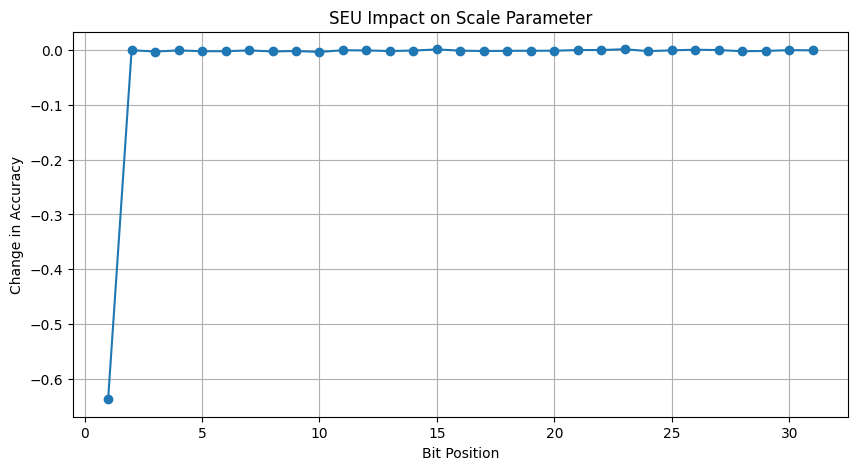

In [23]:
# plot the result in matplotlib
plt.figure(figsize=(10, 5))
plt.plot(range(1, 32), results, marker='o')
plt.title('SEU Impact on Scale Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [24]:
results_loc = []

for i in range(1, 32):
    results_loc.append(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=i, parameter_name="loc", num_samples=10))

Original value: 3.148340940475464, SEU value: 6.749341441734302e-39


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


Accuracy after SEU: 0.7503703703703704
Original value: 3.148340940475464, SEU value: 5.807663958573292e+19


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


Accuracy after SEU: 0.25037037037037035
Original value: 3.148340940475464, SEU value: 13522021376.0


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


Accuracy after SEU: 0.25092592592592594
Original value: 3.148340940475464, SEU value: 206329.671875


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


Accuracy after SEU: 0.25092592592592594
Original value: 3.148340940475464, SEU value: 805.9752807617188


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


Accuracy after SEU: 0.28296296296296297
Original value: 3.148340940475464, SEU value: 50.37345504760742


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


Accuracy after SEU: 0.5590740740740741
Original value: 3.148340940475464, SEU value: 12.593363761901855


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


Accuracy after SEU: 0.7214814814814815
Original value: 3.148340940475464, SEU value: 6.296681880950928


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


Accuracy after SEU: 0.7494444444444445
Original value: 3.148340940475464, SEU value: 2.148340940475464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


Accuracy after SEU: 0.7540740740740741
Original value: 3.148340940475464, SEU value: 3.648340940475464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


Accuracy after SEU: 0.7496296296296296
Original value: 3.148340940475464, SEU value: 3.398340940475464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


Accuracy after SEU: 0.7472222222222222
Original value: 3.148340940475464, SEU value: 3.023340940475464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


Accuracy after SEU: 0.7468518518518519
Original value: 3.148340940475464, SEU value: 3.210840940475464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


Accuracy after SEU: 0.7472222222222222
Original value: 3.148340940475464, SEU value: 3.179590940475464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


Accuracy after SEU: 0.7479629629629629
Original value: 3.148340940475464, SEU value: 3.132715940475464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.38it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 3.148340940475464, SEU value: 3.156153440475464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.51it/s]


Accuracy after SEU: 0.7464814814814815
Original value: 3.148340940475464, SEU value: 3.144434690475464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


Accuracy after SEU: 0.7496296296296296
Original value: 3.148340940475464, SEU value: 3.146387815475464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


Accuracy after SEU: 0.75
Original value: 3.148340940475464, SEU value: 3.147364377975464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 3.148340940475464, SEU value: 3.147852659225464


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


Accuracy after SEU: 0.7472222222222222
Original value: 3.148340940475464, SEU value: 3.148096799850464


Evaluating: 100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 3.148340940475464, SEU value: 3.148218870162964


Evaluating: 100%|██████████| 100/100 [00:11<00:00,  8.69it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 3.148340940475464, SEU value: 3.148401975631714


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.73it/s]


Accuracy after SEU: 0.7507407407407407
Original value: 3.148340940475464, SEU value: 3.148371458053589


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


Accuracy after SEU: 0.7462962962962963
Original value: 3.148340940475464, SEU value: 3.1483256816864014


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.94it/s]


Accuracy after SEU: 0.7501851851851852
Original value: 3.148340940475464, SEU value: 3.1483333110809326


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.73it/s]


Accuracy after SEU: 0.7475925925925926
Original value: 3.148340940475464, SEU value: 3.1483447551727295


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 3.148340940475464, SEU value: 3.148339033126831


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.06it/s]


Accuracy after SEU: 0.7455555555555555
Original value: 3.148340940475464, SEU value: 3.1483418941497803


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.91it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 3.148340940475464, SEU value: 3.1483404636383057


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.63it/s]


Accuracy after SEU: 0.7455555555555555
Original value: 3.148340940475464, SEU value: 3.1483407020568848


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.79it/s]

Accuracy after SEU: 0.7479629629629629


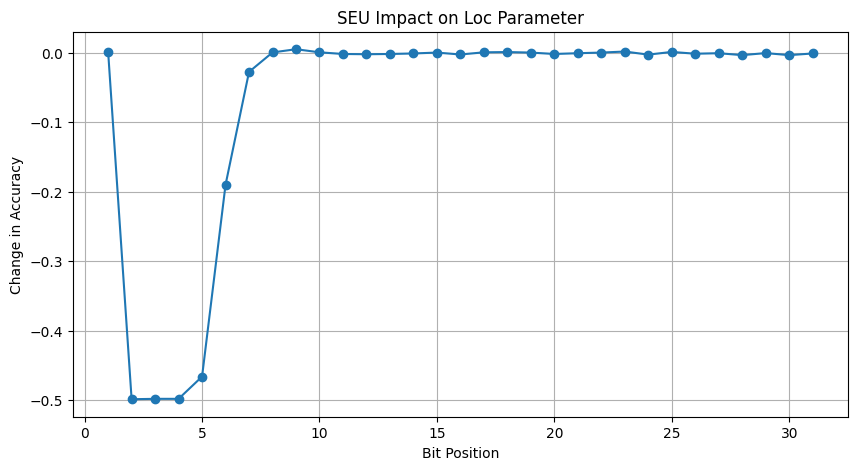

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 32), results_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [26]:
(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=0, parameter_name="loc", num_samples=10))

Original value: 3.148340940475464, SEU value: -3.148340940475464


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.77it/s]

Accuracy after SEU: 0.7435185185185185


np.float64(-0.005555555555555647)